# German Traffic Signal Dataset

# 1: Introduction

The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. Following are the details of the dataset

<br> 1. Single-image, multi-class classification problem
<br> 2. More than 40 classes
<br> 3. More than 50,000 images in total
<br> 4. Large, lifelike database

# 2: Data Pre processing

## 2.1 Loading the required Libraries

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

2.4.1


In [ ]:
! pip install opendatasets --upgrade

In [ ]:
from google.colab import files
files.upload()

import opendatasets as od

dataset_url = 'https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign'
od.download(dataset_url)

Saving kaggle.json to kaggle.json


  3%|▎         | 19.0M/612M [00:00<00:03, 194MB/s]

100%|██████████| 612M/612M [00:04<00:00, 129MB/s]


## 2.2 Get Data

In [ ]:
meta_df = pd.read_csv('/content/gtsrb-german-traffic-sign/Meta.csv')
test_data = pd.read_csv('/content/gtsrb-german-traffic-sign/Test.csv')
train_data = pd.read_csv('/content/gtsrb-german-traffic-sign/Train.csv')

In [ ]:
meta_df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [ ]:
test_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [ ]:
train_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


# 3: Exploring GTRSB dataset

## Q: How many images does the training and testing dataset contain?

In [ ]:
print('Length of training data', len(train_data))
print('Length of testing data',len(test_data))
print(f'Total Images = {len(train_data)} + {len(test_data)} = {len(train_data) + len(test_data)}')

Length of training data 39209
Length of testing data 12630
Total Images = 39209 + 12630 = 51839


## Q: How many output classes does the dataset contain?

In [ ]:
len(train_data.ClassId.value_counts())

43

## Q: What is the shape of an image from the dataset?

In [ ]:
## Reading the image size

import cv2

im1 = cv2.imread('/content/gtsrb-german-traffic-sign/Train/0/00000_00000_00000.png')

im2 = cv2.imread('/content/gtsrb-german-traffic-sign/Train/0/00000_00000_00005.png')

# print(type(im))
# <class 'numpy.ndarray'>

print('Size of image:', im1.shape)
print('Size of image:', im2.shape)
# print(type(im.shape))

Size of image: (30, 29, 3)
Size of image: (31, 31, 3)


It is evident that all the images within the dataset are of different size.

## Q: Let us print a sample image along with along with its class ?

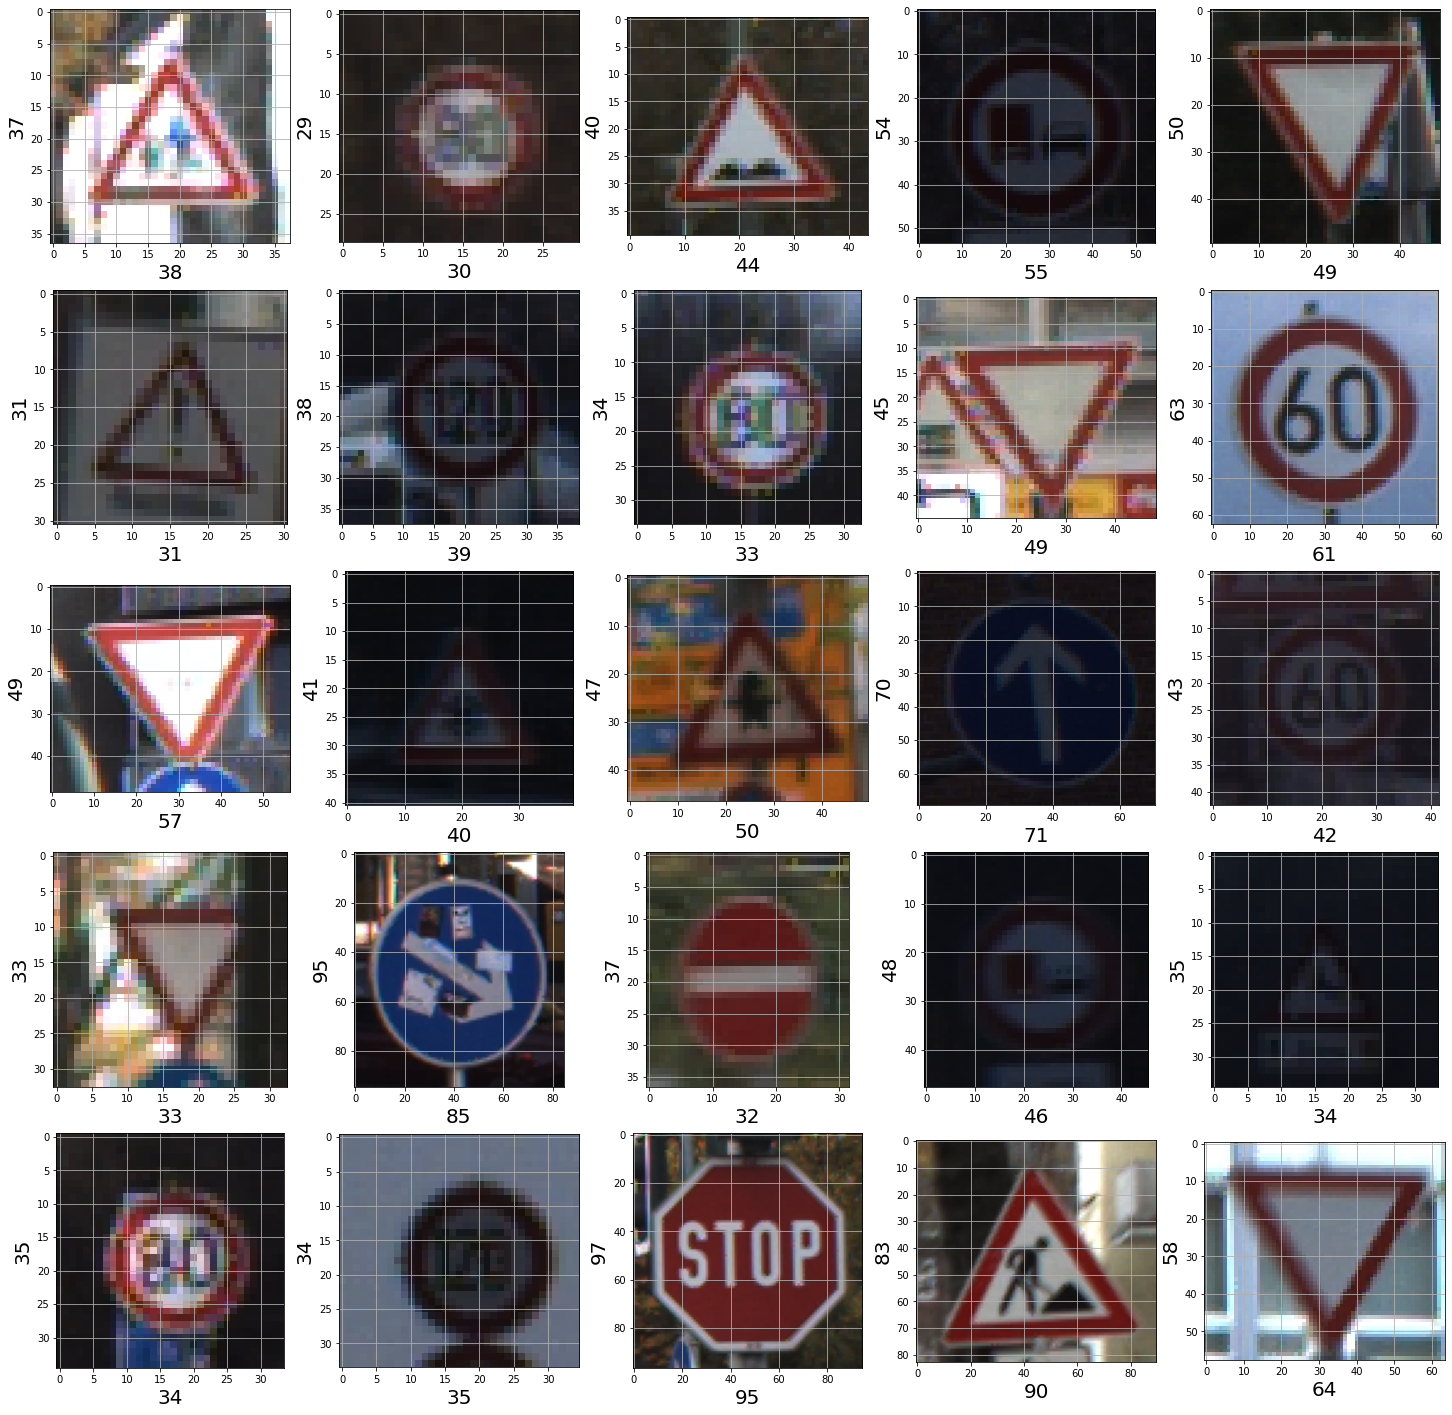

In [ ]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

data_dir = '/content/gtsrb-german-traffic-sign'

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Q: Determine the number of images belonging to each class in training set?

In [ ]:
df = train_data.ClassId.value_counts()
df.sort_index().head()

0     210
1    2220
2    2250
3    1410
4    1980
Name: ClassId, dtype: int64

Text(0, 0.5, 'Images under each Class')

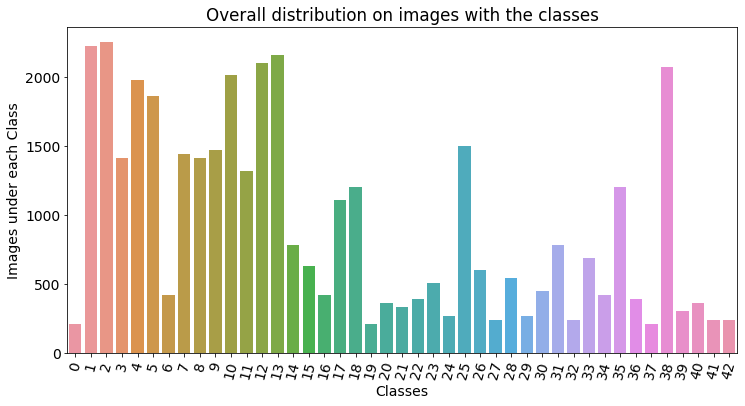

In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

plt.figure(figsize=(12,6))
plt.xticks(rotation=75)
plt.xlabel('Classes')

plt.title('Overall distribution on images with the classes')
sns.barplot(x=df.index, y=df);
plt.ylabel('Images under each Class')

It is observed that few classes seems to have high no of images(like class 2,3..etc.) where as few classes are having very low no of images (like 19, 24...etc)

# 4: Setting up the CNN model

## 4.1 Setting up the ImageDataGenerators
In TensorFlow, data augmentation is accomplished using the ImageDataGenerator class. It is exceedingly simple to understand and to use. The entire dataset is looped over in each epoch, and the images in the dataset are transformed as per the options and values selected.

In [ ]:
## Setting up the Augmentation 

train_dir = '/content/gtsrb-german-traffic-sign/Train'

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)


## 4.2 Configuring the TensorFlow generators

The idea behind using a train generator is to get batches of input and corresponding output on the fly during training process, e.g. reading in 32 images, getting corresponding 32 label vectors and then feeding this set to the gpu for training step.

The flow from directory expects images in each class to be in an independent directory. This is what we had from the begining

In [ ]:
train_generator = train_datagen.flow_from_directory(
     train_dir,  # This is the source directory for training images
     subset='training',
     target_size=(30, 30),  # All images will be resized to 150x150
     batch_size=32,
     color_mode='rgb',    
     shuffle=True,
     seed=42,
        # Since we use binary_crossentropy loss, we need binary labels
     class_mode='categorical')
# Flow validation images in batches of 20 using test_datagen generator
validation_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(30, 30),
        batch_size=32,
        color_mode='rgb',    
        shuffle=True,
        seed=42,
        class_mode='categorical')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


## 4.3 Building the CNN Model

I use the keras wrapper to chain together the layers.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(30,30,3)),
    # tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    # tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(8, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(43, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

# 5: Training the model

## 5.1 Model training and results analysis

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.n//train_generator.batch_size,  
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=validation_generator.n//validation_generator.batch_size)

Epoch 1/10
980/980 [==============================] - 81s 52ms/step - loss: 3.1168 - accuracy: 0.1519 - val_loss: 2.2222 - val_accuracy: 0.3273
Epoch 2/10
980/980 [==============================] - 50s 51ms/step - loss: 1.8136 - accuracy: 0.4233 - val_loss: 1.6636 - val_accuracy: 0.4528
Epoch 3/10
980/980 [==============================] - 50s 51ms/step - loss: 1.3285 - accuracy: 0.5536 - val_loss: 1.3683 - val_accuracy: 0.5562
Epoch 4/10
980/980 [==============================] - 50s 51ms/step - loss: 1.0181 - accuracy: 0.6469 - val_loss: 1.2220 - val_accuracy: 0.6153
Epoch 5/10
980/980 [==============================] - 50s 51ms/step - loss: 0.8218 - accuracy: 0.7207 - val_loss: 1.3398 - val_accuracy: 0.6321
Epoch 6/10
980/980 [==============================] - 50s 51ms/step - loss: 0.6827 - accuracy: 0.7643 - val_loss: 1.0299 - val_accuracy: 0.6824
Epoch 7/10
980/980 [==============================] - 50s 51ms/step - loss: 0.5944 - accuracy: 0.7951 - val_loss: 0.9475 - val_accuracy:

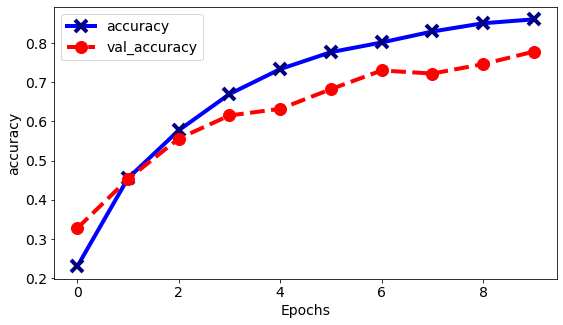

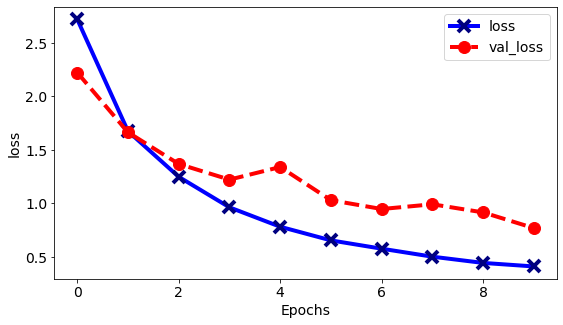

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string], 'b-x', linewidth=4, markersize=12, markeredgewidth=4, markeredgecolor='navy')
  plt.plot(history.history['val_'+string],'r--o', linewidth=4, markersize=12,)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

An accuracy of 82 percent is acheived. Even after training the model for few more epochs the accuray wont improve but we many end of overfitting the model. Let us see how our model is performing on the test dataset.

Note - Our model has never seen the test images hence i would be interesting to see the predictions.

## 5.2 Running the model on test data

As the test images are not categorised to its respective classes, We will pass the folder name which contains all the test images in 'classes' parameter as 'Test'

In [ ]:
test_dir = "/content/gtsrb-german-traffic-sign"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    classes = ['Test'],
    target_size=(30,30),
    batch_size=32,
    color_mode='rgb',    
    shuffle=False,
    seed=42,
    class_mode='categorical')

preds = model.predict_generator(test_generator)

Found 12630 images belonging to 1 classes.


Now I write a block which would map the predictions to the respective immages

In [ ]:
import numpy as np

preds_cls_idx = preds.argmax(axis=-1)
idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
filenames_to_cls = list(zip(test_generator.filenames, preds_cls))

filenames_to_cls[:10]

[('Test/00000.png', '16'),
 ('Test/00001.png', '1'),
 ('Test/00002.png', '38'),
 ('Test/00003.png', '33'),
 ('Test/00004.png', '11'),
 ('Test/00005.png', '38'),
 ('Test/00006.png', '18'),
 ('Test/00007.png', '12'),
 ('Test/00008.png', '25'),
 ('Test/00009.png', '35')]

## 5.3 Accuracy Score

I validate the accuracy of the predicted class against the actual labels. For this I leverage sklearn library

In [ ]:
from sklearn.metrics import accuracy_score

labels = test_data["ClassId"].values

print('Test Data accuracy: ',accuracy_score(labels, preds_cls.astype(int))*100)

Test Data accuracy:  87.2209026128266


This is great we have now achived the accuracy of 87% on the test set.

## 5.4 confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, preds_cls.astype(int))

In [ ]:
test_data.ClassId.values

array([16,  1, 38, ...,  6,  7, 10])

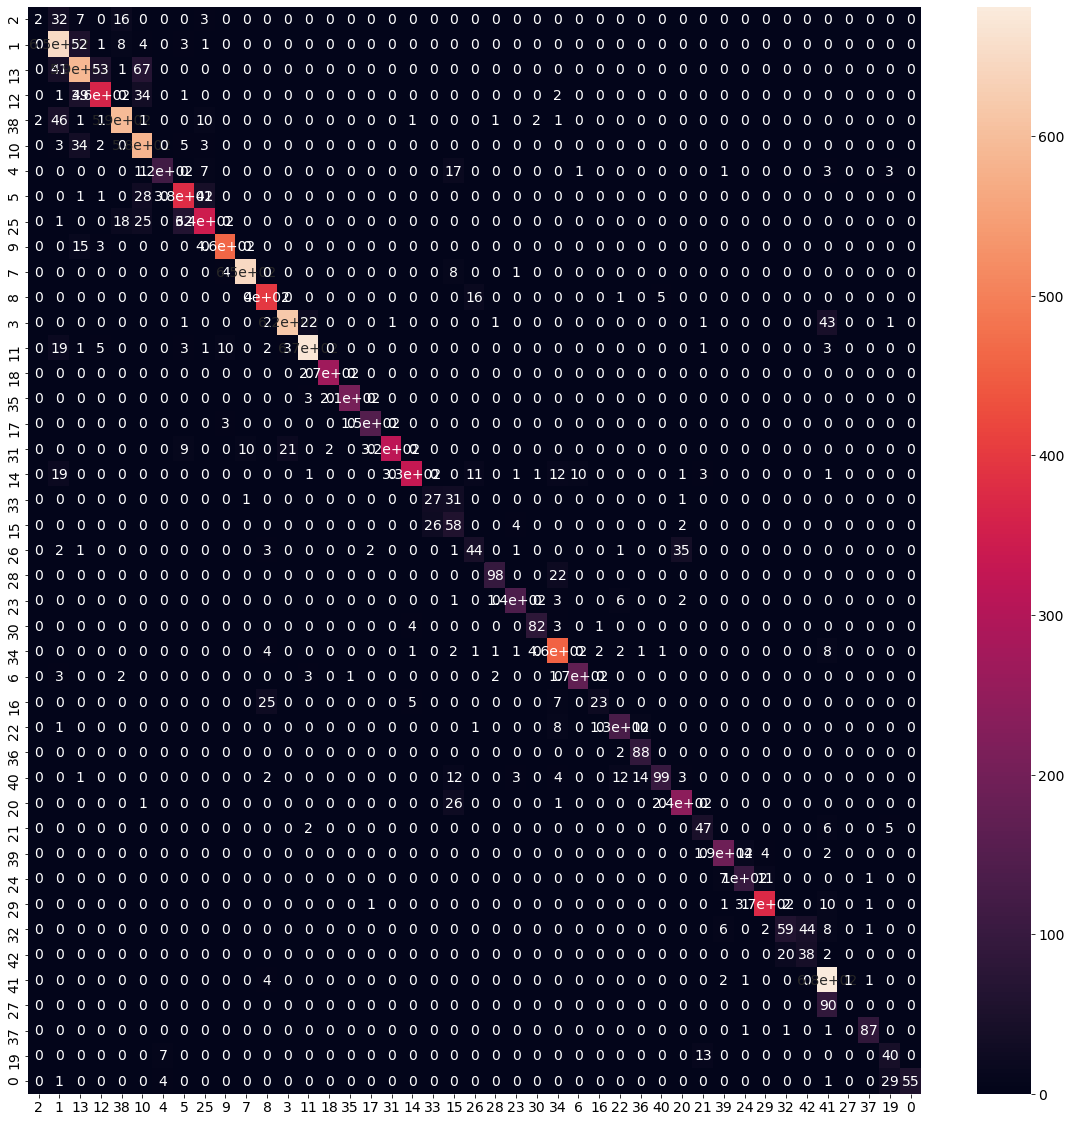

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = df.index,  columns = df.index)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## 5.5 Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds_cls.astype(int)))

              precision    recall  f1-score   support

           0       0.50      0.03      0.06        60
           1       0.79      0.90      0.85       720
           2       0.78      0.78      0.78       750
           3       0.85      0.81      0.83       450
           4       0.93      0.90      0.91       660
           5       0.78      0.93      0.85       630
           6       0.91      0.78      0.84       150
           7       0.82      0.84      0.83       450
           8       0.84      0.76      0.80       450
           9       0.96      0.96      0.96       480
          10       0.98      0.98      0.98       660
          11       0.90      0.95      0.93       420
          12       0.96      0.90      0.93       690
          13       0.96      0.93      0.94       720
          14       0.99      1.00      1.00       270
          15       1.00      0.99      0.99       210
          16       0.98      0.98      0.98       150
          17       1.00    

# 6: Testing with individual images

Let us ramdomly check the predicted and actaul values along with the image.

In [ ]:

from PIL import Image
from sklearn.metrics import accuracy_score

labels = test_data["ClassId"].values
imgs = test_data["Path"].values

data_dir = '/content/gtsrb-german-traffic-sign'

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((30, 30))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

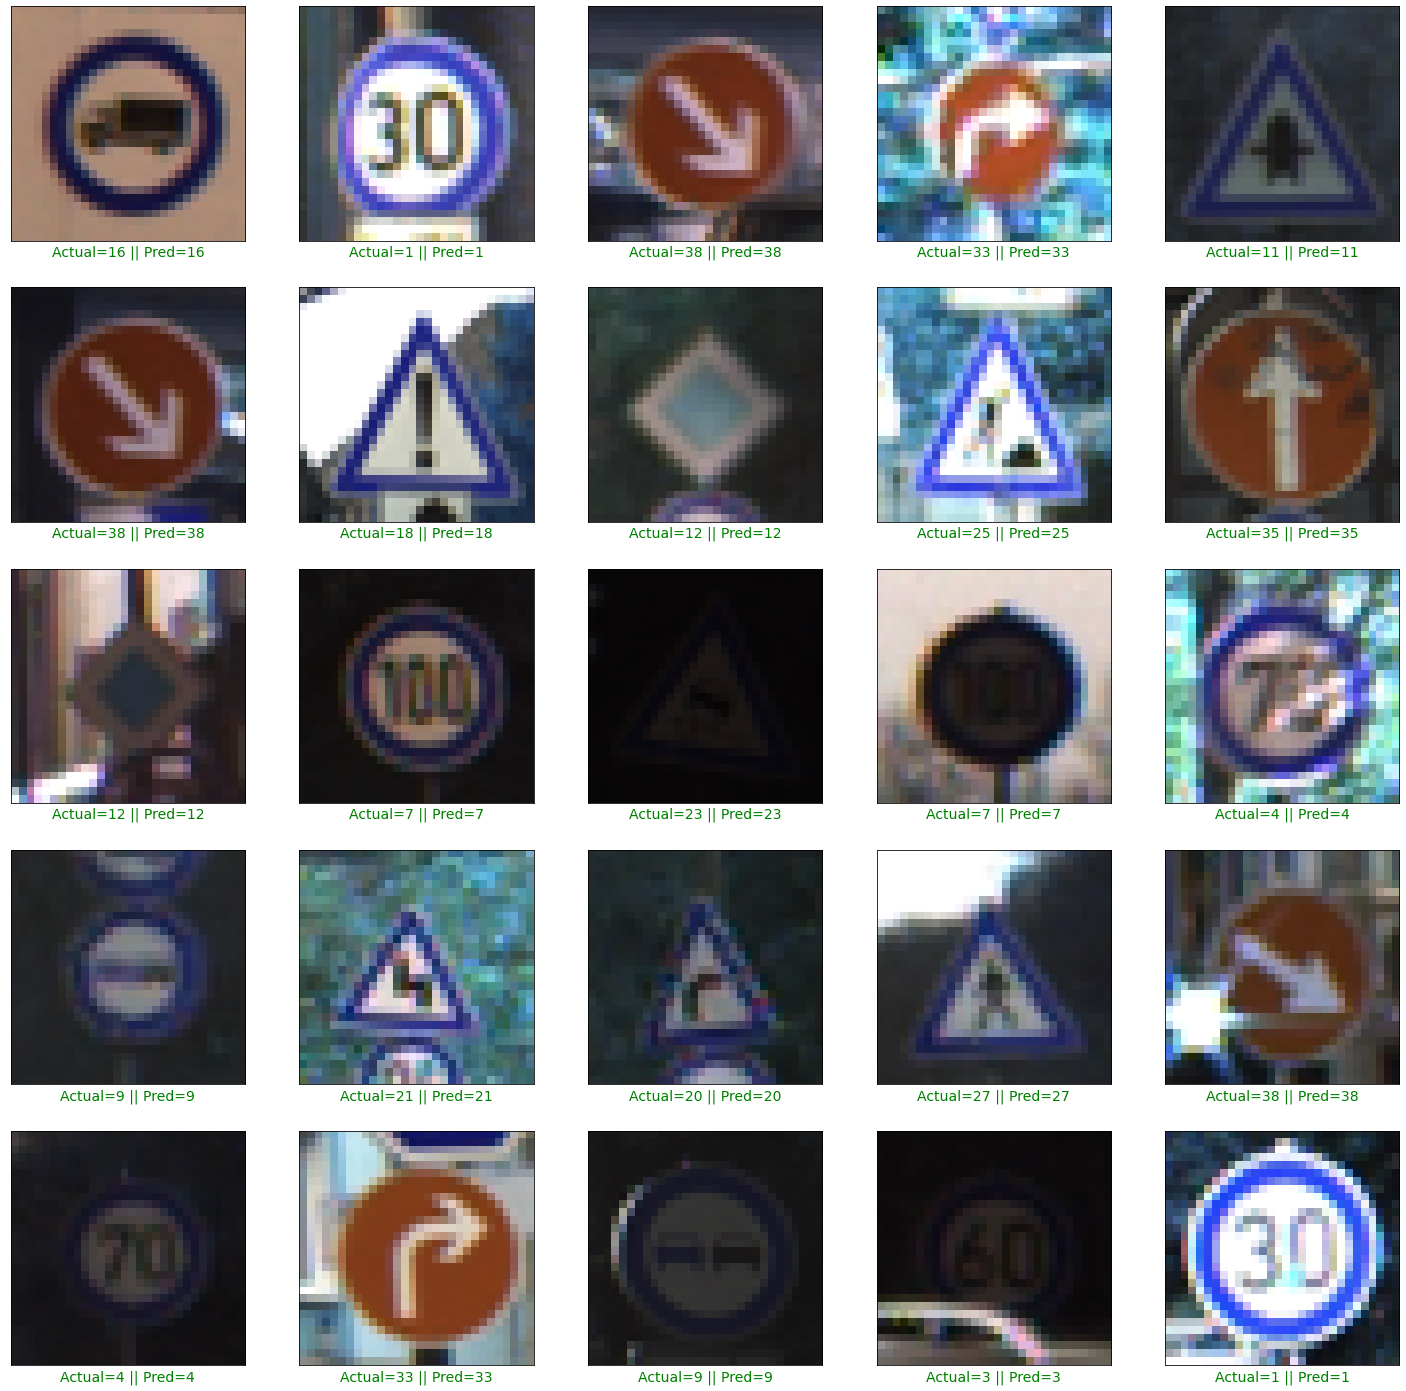

In [ ]:

plt.figure(figsize = (25, 25))

labels = test_data.ClassId.values

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = preds_cls[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction.astype(int) != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()
